# 웹/앱 접속 시간에 따른 지출 현황 분석 및 매출 개선 전략 수립
---
- 분석 목표 : 서비스 내 고객 별 접속 현황과 연간 지출액을 살펴보고, 매출을 높이기 위한 전략을 수립한다.
- 데이터 출처 : [Ecommerce Customers | Kaggle](https://www.kaggle.com/srolka/ecommerce-customers)


## 1. 가설 설정
---
각 컬럼 정보를 확인하고, 분석 목표에 도달하기 위한 가설을 설정한다.

In [109]:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from sklearn import model_selection
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
customer_r = pd.read_csv('./data/customers.csv').iloc[:,3:]
customer_r

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,34.497268,12.655651,39.577668,4.082621,587.951054
1,31.926272,11.109461,37.268959,2.664034,392.204933
2,33.000915,11.330278,37.110597,4.104543,487.547505
3,34.305557,13.717514,36.721283,3.120179,581.852344
4,33.330673,12.795189,37.536653,4.446308,599.406092
...,...,...,...,...,...
495,33.237660,13.566160,36.417985,3.746573,573.847438
496,34.702529,11.695736,37.190268,3.576526,529.049004
497,32.646777,11.499409,38.332576,4.958264,551.620145
498,33.322501,12.391423,36.840086,2.336485,456.469510


각 컬럼은 아래 정보를 담고 있다.<br>
1. Avg.Session Length : 평균 세션 지속 시간
2. Time on App : App 접속 시간
3. Time on Website : Website 접속 시간
4. Length of Membership : 가입 기간
5. Yearly Amount Spent : 연간 지출액


In [4]:
# 결측치 및 데이터 타입 확인
customer_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Avg. Session Length   500 non-null    float64
 1   Time on App           500 non-null    float64
 2   Time on Website       500 non-null    float64
 3   Length of Membership  500 non-null    float64
 4   Yearly Amount Spent   500 non-null    float64
dtypes: float64(5)
memory usage: 19.7 KB


In [5]:
# 데이터 분포 통계 확인
customer_r.describe()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,33.053194,12.052488,37.060445,3.533462,499.314038
std,0.992563,0.994216,1.010489,0.999278,79.314782
min,29.532429,8.508152,33.913847,0.269901,256.670582
25%,32.341822,11.388153,36.349257,2.930450,445.038277
50%,33.082008,11.983231,37.069367,3.533975,498.887875
75%,33.711985,12.753850,37.716432,4.126502,549.313828
max,36.139662,15.126994,40.005182,6.922689,765.518462


각 컬럼의 단위는(분,시간,일,월)는 정확히 알 수 없고, 값이 크고 작다에 대한 인지만 가능한 상황이다. 따라서 이번 분석에는 임의로 주어진 데이터의 단위를 납득 가능한 수준에서 부여하고자 한다.

1. Avg.Session Length (분)
2. Time on App (분)
3. Time on Website (분)
4. Length of Membership (월)
5. Yearly Amount Spent (천 원)

먼저, 세션 길이는 평균 33분으로 `Time on App`, `Time on Website`와 데이터 범위가 매우 유사하다.<br>
두 개의 `Time on ~ ` 컬럼을 빈도(접속 횟수)로 이해하기에는 각 row가 연간 집계 데이터임을 감안할 때 적절하지 않다. 따라서 앞 3개 컬럼은 모두 단위를 '분'으로 통합하겠다. 정보 손실을 피하기 위해 소수점 이하는 제거하지 않고 '초' 이하 단위로 본다.<br>

다음으로 `Length of Membership`의 경우 모든 데이터가 0~12 사이에 분포한다. <br>
'월' 단위로 고려하고, 정보 손실을 피하기 위해 소수점 이하는 제거하지 않고 '일' 이하(일,시간,분..) 단위로 본다.

마지막으로 분석 대상을 대형 플랫폼 기업이 아닌 국내 소규모 커머스로 가정하기 위해 `Yearly Amount Spent`는 '천 원' 단위로 약속하고 마찬가지로 정보 손실을 피하기 위해 소수점 이하는 제거하지 않는다.



In [6]:
# 전처리 전 원본 데이터 복사
customer = customer_r.copy()

# 에러를 줄이기 위해 컬럼명 변경
customer.columns = ['session','app','web','membership','spent']


이미 정제된 데이터라 미리 전처리를 해야할 부분은 없었고 컬럼 이름만 보기 쉽게 정리했다.<br>
이제 본격적으로 분석에 들어가기 전에 어떤 과정을 거치며 최종 결론에 도달할지 단계적 가설을 설정한다.

우리의 분석 목표는 '서비스 내 고객 별 접속 현황과 연간 지출액을 살펴보고, 매출을 높이기 위한 전략을 수립하는 것'이다.<br>
따라서 본 데이터에서 검증하고자 하는 가설은 아래와 같다.(H1 = 연구가설)
1. H1: 유저의 세션 접속 시간이 길수록 연간 지출액은 높다. (주요 컬럼: spent~session)
2. H1: 유저의 가입 기간이 길수록 연간 지출액은 높다. (주요 컬럼: spent~membership)
3. H1: 해당 서비스는 웹보다 앱을 더 많이 사용한다. (주요 컬럼: app~web)
4. H1: 앱 사용 시간이 많을 수록 연간 지출액은 높다. (주요 컬럼: spent~app)
5. H1: 웹 사용 시간이 많을 수록 연간 지출액은 높다. (주요 컬럼: spent~web)
6. H1: 가입 기간에 따라 앱이나 웹 선호도(사용 시간)는 다르다. (주요 컬럼: app+web~membership)

## 2. 가설 검정
---
앞서 설계한 5가지 가설을 순차적으로 검정해나가며 최종 전략을 수립하도록 한다.

### 2-1. 평균 세션 접속 시간에 따른 연간 지출액 확인

평균 세션 접속 시간이 긴 유저라면 충성도가 높을 것이고, 지출액도 높을 것이라 예상해볼 수 있다.<br>
과연 그러한지 상관계수를 통해 확인하고자 한다.

- H0: 유저의 세션 접속 시간과 연간 지출액은 서로 관련이 없다.
- H1: 유저의 세션 접속 시간이 길수록 연간 지출액은 높다.

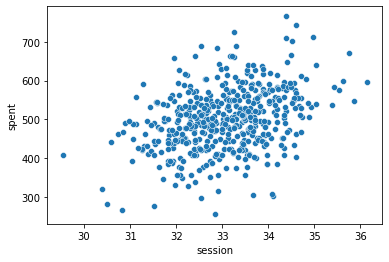

In [15]:
sns.scatterplot(data=customer, x='session',y='spent');

In [11]:
x = customer['session']
y = customer['spent']

# 피어슨 상관계수 확인
stats.pearsonr(x,y)

(0.35508829470764325, 2.6450940333346556e-16)

피어슨 상관분석 결과 p-value는 0에 수렴하고 상관계수는 0.36으로, 약한 양의 상관관계를 확인했다.<br>

**결론:**<br>
**평균 세션 지속 시간은 연간 지출액과 양의 상관관계가 있다. 귀무가설을 기각한다.**<br>
하지만 연관성이 강하지 않고, 모든 서비스가 그러하든 수치로 판단할 수 없는 많은 잠재 변수가 존재한다. <br>
따라서 세션 지속 시간이 길기 **"때문에"** 연간 지출액이 상승하는 것인지 그 **"인과성"**을 확인할 수는 없다.<br>
다만, 세션 지속 시간이 긴 유저는 본 서비스 매출에 기여하는 고객으로 해석할 수 있다.



### 2-2. 가입 기간에 따른 연간 지출액 확인

일반적으로 가입 기간과 지출액은 관련이 크지 않다.<br>
점점 커머스 시장이 커지고 복잡해지면서 가입한 서비스를 굳이 해지하기보다 가입한 채 사용하지 않는 경향이 많기 때문이다.<br>

그러나 만약 본 서비스가 사용 기간에 따라 충성도가 크고, 리텐션이 매우 좋은 서비스라면 가입 기간에 따라 연간 지출액이 높아질 수 있다.<br>
따라서 리텐션 효율이 좋은 서비스인지 알아보기 위해 가입 기간에 따른 연간 지출액을 확인하고자 한다.<br>

- H0: 유저의 가입 기간과 연간 지출액은 서로 관련이 없다.
- H1: 유저의 가입 기간이 길수록 연간 지출액은 높다.


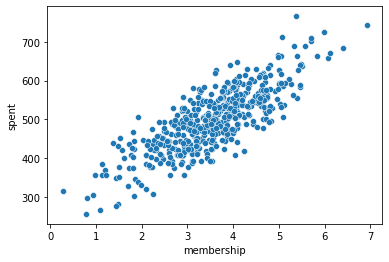

In [16]:
sns.scatterplot(data=customer, x='membership', y='spent');

매우 강한 선형 관계를 보인다. 구체화하기 위해 상관계수를 이어서 확인해보도록 한다.

In [17]:
x = customer['membership']
y = customer['spent']

# 피어슨 상관계수 확인
stats.pearsonr(x,y)

(0.809083568247581, 4.806615782583552e-117)

상관계수는 0.81, p-value는 0에 강하게 수렴한다. 강한 양의 상관관계를 보인다.

**결론:**<br>
**유저의 가입 기간과 연간 지출액은 강한 양의 상관관계가 있다. 귀무가설을 기각한다.**<br>
평균 세션 유지 시간과 마찬가지로 가입 기간이 **길어서** 연간 지출액이 높다는 **인과성**을 확인할 수는 없다.<br>
하지만 본 서비스가 가입 이후의 고객 경험이 매우 좋고, 시간에 따라 매출에 기여하는 충성고객 비율이 높다고 이해할 수 있다.


### 2-3. 웹, 앱 사용 시간 비교

[3월까지 쇼핑 앱 사용자수 '3500만'- 70%가 앱으로 쇼핑, 정보통신신문](https://www.koit.co.kr/news/articleView.html?idxno=82667)

위 기사를 근거로 본 서비스는 앱 사용빈도가 높을 것이라 예상할 수 있다.<br>
하지만 데이터에서 구매 경로를 확인할 수 없기 때문에, 웹의 사용시간과 앱 사용시간을 통해 간접적으로 구매 경로에 대한 유저 선호도를 확인해보고자 한다.

- H0: 해당 서비스는 웹보다 앱을 더 적게 사용하거나 사용 시간이 동일하다.
- H1: 해당 서비스는 웹보다 앱을 더 많이 사용한다.

In [22]:
# 전체 구매 경로(app, web) 중 app 사용 비율
customer['app_per'] = customer['app'] / (customer['app'] + customer['web'])

customer['app_per'].describe()

count    500.000000
mean       0.245180
std        0.015740
min        0.193497
25%        0.234936
50%        0.245531
75%        0.257707
max        0.289320
Name: app_per, dtype: float64

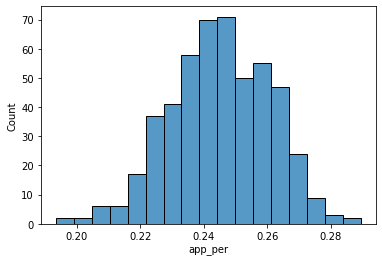

In [25]:
sns.histplot(customer['app_per']);

**결론:**<br>
**모든 유저의 앱 사용 비율은 최대 30%를 넘지 않는다. 연구가설을 기각한다.**<br>
본 서비스는 예상과 달리 웹 사용 비율이 더 높다. 그러나 웹 사용 비율이 높은 것이 매출에 기여하는지는 알 수 없다.<br>
따라서 앱 사용 시간에 따른 연간 지출액과 웹 사용 시간에 따른 연간 지출액을 비교해서 두 판매 경로의 효율을 체크할 필요가 있다.

### 2-4. 앱 사용 시간에 따른 연간 지출액 확인

앞서 확인한 것처럼 본 서비스는 웹 사용 비율이 더 높다.<br>
그러나 국내 쇼핑의 70%가 앱에서 이루어진다는 보도를 고려할 때, 실제 매출은 웹 보다 앱에서 주로 발생할 가능성이 크다.<br>
따라서 앱 사용 시간에 따른 연간 지출액을 상관분석을 통해 확인하고자 한다.

- H0: 앱 사용 시간과 연간 지출액은 서로 관련이 없다.
- H1: 앱 사용 시간이 많을 수록 연간 지출액은 높다.

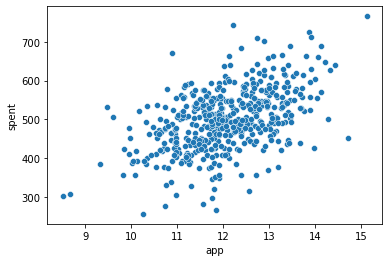

In [27]:
sns.scatterplot(data=customer, x='app', y='spent');

산점도로 볼 때, 선형 관계가 있는 것 같다. 이어서 상관계수를 통해 확인한다.

In [28]:
x=customer['app']
y=customer['spent']

stats.pearsonr(x,y)

(0.4993277700534505, 6.905842369970937e-33)

상관분석 결과 상관계수는 0.5, p-value는 0에 수렴하여 양의 상관관계가 존재함을 알 수 있다.

**결론:**<br>
**유저의 app 사용 시간은 연간 지출액과 관련이 있다. 분석 결과 양의 상관관계가 있으므로 귀무가설을 기각한다.**<br>
이어서 web 사용 시간과 연간 지출액의 상관 분석 결과를 비교하면, 어떤 구매 경로가 더 효율이 좋은지 확인할 수 있다.

### 2-5. 웹 사용 시간에 따른 연간 지출액 확인

앱과 마찬가지로 웹 사용 시간도 연간 지출액과 관련이 있을 것이라 예상할 수 있다.<br>
앱보다 사용 비율이 압도적으로 높고, 서비스를 사용한다는 것은 작은 결제라도 연결되기 때문이다.<br>

분석을 통해 상관계수를 확인하고, 앞에서 확인한 app 사용 시간과 연간 지출액의 상관계수와 비교하도록 한다.

- H0: 웹 사용 시간과 연간 지출액은 서로 관련이 없다.
- H1: 웹 사용 시간이 많을 수록 연간 지출액은 높다.

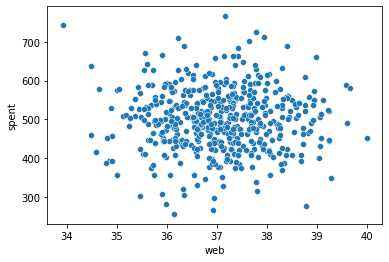

In [30]:
sns.scatterplot(data=customer, x='web', y='spent');

시각적으로는 `app`과 `spent`의 관계보다 상관성이 약해보인다. 이어서 피어슨 상관계수를 확인해보겠다.

In [31]:
x = customer['web']
y = customer['spent']

stats.pearsonr(x,y)

(-0.002640844672158962, 0.9530290603515617)

예상과 달리 상관관계가 없다. p_value는 0.5보다 크고 상관계수를 신뢰할 수 없기에 app, web 사용 시간 별 연간 지출액에 대한 결론은 아래와 같이 정리한다.


**결론:**<br>
**예상과 달리 web 사용 시간과 연간 지출액은 서로 관련이 없었다. 연구가설을 기각한다.**<br>
`2-3`, `2-4`와 종합하면, 유저는 웹에서 시간을 많이 보내지만 실제 결제는 app을 통해 발생하는 것을 알 수 있다.<br>
전략적으로 결제가 발생하는 app 사용 시간을 늘리기 위한 서비스 개편이 필요해보인다.

### 2-6. 가입 기간에 따른 구매 경로에 대한 선호도 차이 분석

마지막으로, 가입 기간으로 고객 그룹을 나누기 위해<br>
가입 기간에 따라 웹 사용 시간과 앱 사용 시간을 확인한다.

그룹을 나누는 것은 고객군 별 매출 향상을 위한 전략을 달리 설계하기 위함이다.

- H0: 가입 기간에 따라 앱이나 웹 선호도(사용 시간)는 서로 차이가 없다.
- H1: 가입 기간에 따라 앱이나 웹 선호도(사용 시간)는 다르다.

먼저, 가입 기간을 각각 유효한 그룹으로 나누기 위해 분포를 확인한다.

In [33]:
customer['membership'].describe()

count    500.000000
mean       3.533462
std        0.999278
min        0.269901
25%        2.930450
50%        3.533975
75%        4.126502
max        6.922689
Name: membership, dtype: float64

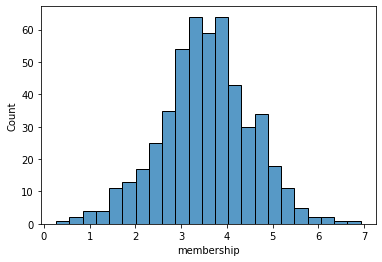

In [35]:
sns.histplot(customer['membership']);

데이터가 정규분포를 따른다. 그룹은 중위수(50%)를 기준으로 2개로 나누도록 한다.

In [43]:
md = np.median(customer['membership'])

customer['group'] = customer['membership'].apply(lambda x:'A' if x < md else 'B')

customer['group'].value_counts()

B    250
A    250
Name: group, dtype: int64

In [64]:
customer.loc[customer['group']=='B','app'].describe()

count    250.000000
mean      12.076809
std        1.004755
min        9.477778
25%       11.365706
50%       12.013014
75%       12.777711
max       15.126994
Name: app, dtype: float64

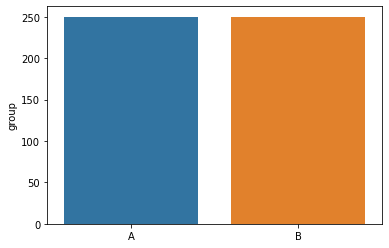

In [52]:
# group 별 분포 시각화
sns.barplot(x=['A','B'], y=customer['group'].value_counts());

In [61]:
print('서비스 사용 기간이 평균 미만인 고객의 평균 app 사용 시간 : {:.2f}'.\
      format(customer.loc[customer['group']=='A','app'].mean()))

print('서비스 사용 기간이 평균 미만인 고객의 평균 web 사용 시간 : {:.2f}'.\
      format(customer.loc[customer['group']=='A','web'].mean()))

서비스 사용 기간이 평균 미만인 고객의 평균 app 사용 시간 : 12.03
서비스 사용 기간이 평균 미만인 고객의 평균 web 사용 시간 : 37.05


In [62]:
print('서비스 사용 기간이 평균 이상인 고객의 평균 app 사용 시간 : {:.2f}'.\
      format(customer.loc[customer['group']=='B','app'].mean()))

print('서비스 사용 기간이 평균 이상인 고객의 평균 web 사용 시간 : {:.2f}'.\
      format(customer.loc[customer['group']=='B','web'].mean()))

서비스 사용 기간이 평균 이상인 고객의 평균 app 사용 시간 : 12.08
서비스 사용 기간이 평균 이상인 고객의 평균 web 사용 시간 : 37.07


각 그룹 별 app, web 사용 시간에 유의미한 차이가 있다고 보기 어렵다. 두 그룹 모두 web을 선호한다.

**결론:**<br>
**서비스 사용 기간(가입 기간)에 따라 구매 경로(app, web)에 대한 선호도는 차이가 없다. 연구가설을 기각한다.**<br>
그러나 앞서 확인한 것처럼 실제 구매가 발생하는 곳은 app이므로 web 사용자를 app으로 옮겨올 필요가 있다.<br>
app에 대한 선호도를 높일 수 있다면, app 사용 시간을 늘리고 연간 지출액을 증가시킬 수 있다.

### 2-7. 가입 기간에 따른 구매 경로 별 연간 지출액 확인

가입 기간과 상관없이 모두 web을 선호하고, app 사용 시간 및 web 사용 시간에 차이가 없었다.<br>
그렇다면 서비스 이용 시간이 동일하다면, web과 app 모두에서 가입 기간이 긴 유저가 연간 지출액이 높을지 확인하고자 한다.<br>
앞서 가입 기간이 길수록 연간 지출액이 높다는 것을 확인했기 때문에 web, app 동일하게 그러한지 파악하기 위함이다.

- H0: app, web 둘 중 하나만 가입 기간이 오래된 그룹(B)이 연간 지출액이 높다.
- H1: app, web 모두 가입 기간이 오래된 그룹(B)이 연간 지출액이 높다.

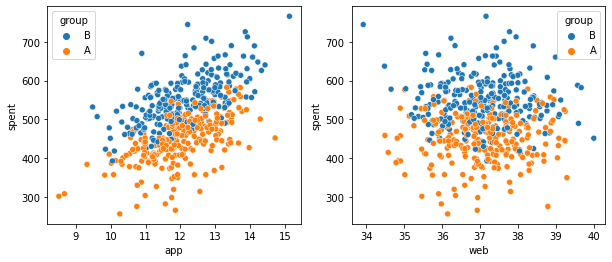

In [53]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

# app/web 사용 시간에 따른 연간 지출액을 그룹으로 나눠 확인한다.
sns.scatterplot(data=customer, x='app', y='spent', hue='group', ax=axes[0])
sns.scatterplot(data=customer, x='web', y='spent', hue='group', ax=axes[1])

plt.show()

두 구매 경로(app, web) 모두 B 그룹이 연간 지출액이 높은 경향을 보인다. 귀무가설을 기각한다.<br>
차이가 분명하게 있으므로 그룹을 2개로 나누지 않고 모든 가입 기간에 대해 산점도를 확인해보겠다.

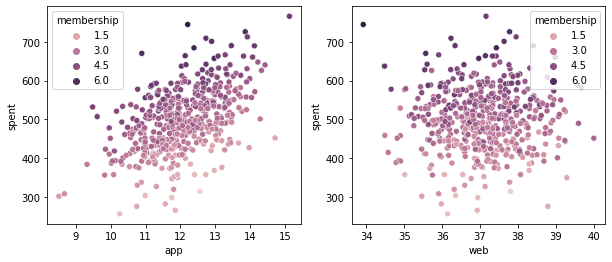

In [65]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

# app/web 사용 시간에 따른 연간 지출액을 그룹으로 나눠 확인한다.
sns.scatterplot(data=customer, x='app', y='spent', hue='membership', ax=axes[0])
sns.scatterplot(data=customer, x='web', y='spent', hue='membership', ax=axes[1])

plt.show()

**결론:**<br>
**두 구매 경로(app, web) 모두 서비스 사용 기간(가입 기간)이 길면 연간 지출액도 높다.**<br>
`2-6`과 종합하면, 모든 가입 기간과 모든 구매 경로에 대해서 고객은 일관성 있는 특징을 보인다.<br>
즉, 가입 기간 별로 고객 그룹을 나눈다거나 구매 경로 별 선호도 기반으로 고객 그룹을 나눌 수 없다.<br>
따라서 매출 개선 전략 타겟은 고객군을 나누지 않고 전체 유저를 대상으로 한다.

## 3. 분석 결과
---

아래 7가지 가설 검정 과정을 통해 **웹/앱 접속 시간에 따른 지출 현황**을 분석해보았다.

1. H1: 유저의 세션 접속 시간이 길수록 연간 지출액은 높다. 
2. H1: 유저의 가입 기간이 길수록 연간 지출액은 높다.
3. H1: 해당 서비스는 웹보다 앱을 더 많이 사용한다.
4. H1: 앱 사용 시간이 많을 수록 연간 지출액은 높다.
5. H1: 웹 사용 시간이 많을 수록 연간 지출액은 높다.
6. H1: 가입 기간에 따라 앱이나 웹 선호도(사용 시간)는 다르다.
7. H1: app, web 모두 가입 기간이 오래된 그룹(B)이 연간 지출액이 높다.

정리하면,<br>
유저의 가입 기간이 길수록 지출액이 높다는 점에서 충성 고객이 많은 고효율 서비스다.<br>
결제는 app에서 발생하지만 사용자가 web에 머무는 시간이 더 많다.<br>
이는 가입 기간이 길더라도 동일하게 나타나는 현상이다.<br>

분석을 토대로 아래의 방법으로 매출 개선을 시도해볼 수 있다.<br>

**매출 개선 전략 :**<br>
**web에서 사용자가 머무는 주요 페이지를 app에 최적화하여 점진적으로 app 사용 시간을 늘린다.**

## 4. 매출 개선 시뮬레이션
---

app 사용 비중이 늘어났을 때 어느 정도의 매출 개선이 예상되는지 회귀 분석을 통해 예측해보도록 한다.

In [74]:
# 회귀분석 목적으로 새로운 데이터프레임을 다시 생성
ct_lin = customer_r.copy()
ct_lin.columns = ['session','app','web','membership','spent']

# 정규성 검정
for col in ct_lin.columns:
    st, pv = stats.kstest(ct_lin[col],'norm')
    print('vector : {} - p_value : {}'.format(col,pv))
    if pv < 0.05:
        print('--> 정규분포 O')
    else:
        print('--> 정규분포 X')

vector : session - p_value : 0.0
--> 정규분포 O
vector : app - p_value : 0.0
--> 정규분포 O
vector : web - p_value : 0.0
--> 정규분포 O
vector : membership - p_value : 0.0
--> 정규분포 O
vector : spent - p_value : 0.0
--> 정규분포 O


In [138]:
X = ct_lin.iloc[:,:-1] # spent 제외 나머지 모든 컬럼
X_ = (X - np.min(X))/(np.max(X)-np.min(X)) # 독립변수 정규화 작업

y = ct_lin.iloc[:,-1] # spent

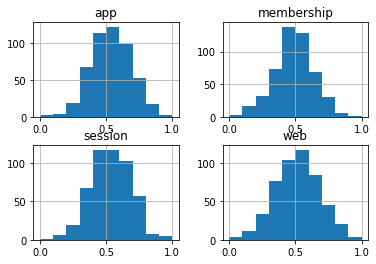

In [139]:
# 표준화된 독립변수 분포 확인
X_.hist();

회귀분석의 신뢰도 확보를 위해 변수들의 정규성을 검정했고,<br>
회귀분석의 정확도를 높이기 위해 모든 컬럼의 데이터 범위를 0과 1 사이로 통일시켰다.<br>

다음으로 테스트셋을 따로 분리하고 예측할 모델 성능을 평가한다.

In [182]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_,y,test_size=0.2,shuffle=True)

# 데이터가 잘 분할되었는지 확인
print('The distribution of training set : {} and {}'.format(X_train.shape, y_train.shape))
print('The distribution of test set : {} and {}'.format(X_test.shape, y_test.shape))

The distribution of training set : (400, 4) and (400,)
The distribution of test set : (100, 4) and (100,)


In [183]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.predict(X_test)

array([478.51058369, 449.88143676, 411.39031632, 530.3528004 ,
       488.21386745, 449.73882129, 565.33149069, 491.37434266,
       381.29515047, 398.97215612, 554.53025792, 460.71323737,
       589.64343949, 409.31004883, 609.23503452, 418.30819157,
       448.25048868, 500.68451076, 525.98929327, 527.94173467,
       627.91669757, 606.15396051, 498.16392866, 519.19453143,
       703.10815952, 533.95199327, 623.12370825, 571.83177477,
       347.94951233, 514.09880783, 479.43710906, 540.20256643,
       494.06564279, 501.40467521, 484.69696931, 616.65667535,
       497.52537355, 505.35428713, 495.37792452, 284.01048684,
       424.28292475, 536.23633553, 501.99175929, 549.80182898,
       464.26833261, 506.88692522, 518.49951848, 608.60628647,
       424.87394181, 423.67045631, 478.83072748, 472.18810295,
       590.66708726, 523.75155655, 523.16045797, 413.09116445,
       598.72923402, 473.31721848, 465.05781685, 414.35281299,
       475.49375111, 511.31138277, 439.8882148 , 435.69

In [184]:
# 모델 정확도 확인
lr.score(X_test, y_test)

0.989284333947629

매우 높은 예측 정확도를 가진 선형 회귀 모델을 완성했다.<br>
이 모델을 사용해 app 사용 시간이 늘어남에 따라 연간 지출액이 어떻게 상승할지 예측해본다.<br>

먼저, 테스트셋에서 하나의 샘플을 추출하여 app 사용 시간을 점진적으로 늘린 새로운 테이블을 생성한다.<br>
*(사용자 수는 동일하다는 가정 하에, app 사용 시간은 10%씩 늘어나고 web 사용 시간은 10%씩 감소시키는 것으로 논의를 단순화한다)*

In [185]:
# 테스트셋 확인
X_

,session,app,web,membership
0,0.751425,0.626620,0.929816,0.573101
1,0.362306,0.393016,0.550801,0.359869
2,0.524953,0.426378,0.524803,0.576396
3,0.722409,0.787050,0.460890,0.428434
4,0.574861,0.647702,0.594748,0.627768
...,...,...,...,...
495,0.560784,0.764183,0.411098,0.522589
496,0.782491,0.481592,0.537882,0.497028
497,0.471354,0.451931,0.725412,0.704722
498,0.573625,0.586699,0.480394,0.310634


In [186]:
# 무작위 인덱스 설정
idx = np.random.randint(10)
idx

4

In [187]:
# 무작위로 1개 샘플 추출
sample = X_test.iloc[idx]
sample

session       0.217829
app           0.486975
web           0.354718
membership    0.624770
Name: 482, dtype: float64

In [188]:
sample['session']

0.21782894037206957

In [189]:
pers = np.arange(0,1,0.1) # 0부터 0.9까지 0.1씩 증가하는 배열 생성

session_list = []
app_list = []
web_list = []
membership_list = []

for p in pers: 
    session_list.append(sample['session'])
    app_list.append(sample['app']*(1+p))
    web_list.append(sample['web']*(1-p))
    membership_list.append(sample['membership'])

test_dict = {
    'session':session_list,
    'app':app_list,
    'web':web_list,
    'membership':membership_list
}

# 데이터프레임 생성
testset = pd.DataFrame(test_dict)
testset

,session,app,web,membership
0,0.217829,0.486975,0.354718,0.62477
1,0.217829,0.535673,0.319246,0.62477
2,0.217829,0.584370,0.283774,0.62477
3,0.217829,0.633068,0.248302,0.62477
4,0.217829,0.681765,0.212831,0.62477
5,0.217829,0.730463,0.177359,0.62477
6,0.217829,0.779160,0.141887,0.62477
7,0.217829,0.827858,0.106415,0.62477
8,0.217829,0.876555,0.070944,0.62477
9,0.217829,0.925253,0.035472,0.62477


`session`과 `membership`은 동일하고 `app`은 10%씩 증가, `web`은 10%씩 감소하는 데이터테이블을 생성했다.<br>

이제 앞에서 만든 모델에 데이터를 넣고 연간 지출액을 예측해본다.

In [190]:
lr.predict(testset)

array([488.21386745, 500.62367008, 513.0334727 , 525.44327532,
       537.85307795, 550.26288057, 562.6726832 , 575.08248582,
       587.49228845, 599.90209107])

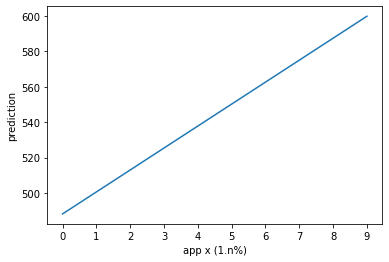

In [203]:
sns.lineplot(x=np.arange(0,10,1), y=lr.predict(testset).tolist())

plt.xticks(np.arange(0,10,1))
plt.xlabel('app x (1.n%)')
plt.ylabel('prediction')
plt.show()

In [206]:
# 앱 사용 시간 증가에 따른 연간 지출액 증가율
pd.DataFrame(lr.predict(testset)).pct_change()

,0
0,NaN
1,0.025419
2,0.024789
3,0.024189
4,0.023618
5,0.023073
6,0.022552
7,0.022055
8,0.021579
9,0.021123


**유저의 app 사용 시간이 10%씩 늘어남에 따라 연간 지출액은 2%씩 상승한다.** <br>
web 사용 시간을 10%씩 줄였음에도 지출액 증가를 보이는 것은 매우 유의미하다.<br>
또한 무작위로 추출한 유저(`sample` 행)의 실제 연간 지출액을 보면 아래와 같이 예측값과 차이가 크지 않다.<br>

In [208]:
# sample 유저의 실제 연간 지출액
y_test.iloc[idx]

494.6386097568927

In [210]:
# sample 유저의 예상 연간 지출액
lr.predict(testset)[0]

488.2138674508592

**시뮬레이션 결과:**<br>
유저의 app 사용 시간을 기존 대비 10%씩 늘릴 수 있다면 연간 지출액은 2%씩 상승 가능하다.<br>
따라서 현재 web에서 머무는 시간이 많은 페이지를 확인하여 app에서도 동일하게 서비스를 이용할 수 있도록 하고,<br>
점차적으로 app의 사용성을 개선하여 web에서 app으로 전환하는 비율을 높이면서 동시에 신규 사용자를 app으로 유치시키는 전략을 취하는 것이 좋겠다.